In [3]:
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.layers import *
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from keras.callbacks import EarlyStopping
import tensorflow as tf

2022-08-11 08:18:44.123448: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-11 08:18:44.123468: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
df = pdr.get_data_yahoo('GOOG')
df = df[['Close']]
TEST_SIZE = 0.05
VALIDATION_SIZE = 0.05
TRAIN_SIZE = 1 - TEST_SIZE - VALIDATION_SIZE

train_ending_index = int(len(df) * TRAIN_SIZE)
validation_ending_index = train_ending_index + int(len(df) * VALIDATION_SIZE)

train_df = df[:train_ending_index]
validation_df = df[train_ending_index:validation_ending_index]
test_df = df[validation_ending_index:]

train_max = train_df['Close'].max()
train_min = train_df['Close'].min()

train_df_scaled = (train_df['Close'] - train_min) / (train_max - train_min)
validation_df_scaled = (validation_df['Close'] - train_min) / (train_max - train_min)
test_df_scaled = (test_df['Close'] - train_min) / (train_max - train_min)

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i+look_back)]
        X.append(a)
        Y.append(dataset[i + look_back])
    X = np.asarray(X).astype(np.float32)
    Y = np.asarray(Y).astype(np.float32)
    return np.array(X).reshape(X.shape[0], X.shape[1], 1), np.array(Y)

LOOKBACK = 20

x_train, y_train = create_dataset(train_df_scaled, look_back = LOOKBACK)
x_validation, y_validation = create_dataset(validation_df_scaled, look_back = LOOKBACK)
x_test, y_test = create_dataset(test_df_scaled, look_back = LOOKBACK)

In [4]:
from typing import Tuple
def train_model(
    layer_sizes: Tuple[int, int],
    dropout: float,
    learning_rate: float,
):
    model = Sequential()

    # Adding the LSTM layer and some Dropout regularisation
    input_shape = x_train.shape[1]
    for i, layer_size in enumerate(layer_sizes):
        model.add(LSTM(layer_size, return_sequences = i < (len(layer_sizes) - 1), input_shape=(input_shape, 1)))
        model.add(Dropout(dropout))
        input_shape = layer_size

    # Adding the output layer
    # For Full connection layer we use dense
    # As the output is 1D so we use unit=1
    model.add(Dense(1))

    # Compiling the RNN-LSTM
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss='mean_squared_error', optimizer=optimizer)

    # Fitting the RNN to the Training set
    history = model.fit(x_train, y_train, epochs=50, batch_size=32, validation_data=(x_validation, y_validation),
                        callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=True)

    # Show the model summary
    print(model.summary())
    return model, history


In [5]:
model, history = train_model(
    layer_sizes=(100, 100),
    dropout=0.2,
    learning_rate=1e-3,
)

2022-08-11 08:18:51.421191: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_INVALID_DEVICE: invalid device ordinal
2022-08-11 08:18:51.421257: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: dajan
2022-08-11 08:18:51.421266: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: dajan
2022-08-11 08:18:51.421429: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.141.3
2022-08-11 08:18:51.421463: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.141.3
2022-08-11 08:18:51.421471: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 470.141.3
2022-08-11 08:18:51.428609: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performanc

Epoch 1/50
35/35 [==============================] - 3s 23ms/step - loss: 0.0186 - val_loss: 0.0039
Epoch 2/50
35/35 [==============================] - 0s 11ms/step - loss: 0.0018 - val_loss: 0.0040
Epoch 3/50
35/35 [==============================] - 0s 11ms/step - loss: 0.0019 - val_loss: 0.0050
Epoch 4/50
35/35 [==============================] - 0s 11ms/step - loss: 0.0015 - val_loss: 0.0036
Epoch 5/50
35/35 [==============================] - 0s 11ms/step - loss: 0.0017 - val_loss: 0.0037
Epoch 6/50
35/35 [==============================] - 0s 12ms/step - loss: 0.0015 - val_loss: 0.0034
Epoch 7/50
35/35 [==============================] - 0s 11ms/step - loss: 0.0015 - val_loss: 0.0035
Epoch 8/50
35/35 [==============================] - 0s 11ms/step - loss: 0.0015 - val_loss: 0.0034
Epoch 9/50
35/35 [==============================] - 0s 11ms/step - loss: 0.0014 - val_loss: 0.0070
Epoch 10/50
35/35 [==============================] - 0s 11ms/step - loss: 0.0014 - val_loss: 0.0045
Epoch 11/

In [7]:
def evaluate_model(model, data, labels, train_min, train_max, prefix):
    predictions = model.predict(data)
    unscaled_predictions = predictions * (train_max - train_min) + train_min
    unscaled_labels = labels * (train_max - train_min) + train_min
    print(f'{prefix} Mean Absolute Error (MAE):', mean_absolute_error(unscaled_labels, unscaled_predictions[:,0]))
    print(f'{prefix} Root Mean Squared Error (RMSE):', np.sqrt(mean_squared_error(unscaled_labels, unscaled_predictions[:,0])))
    print(f'{prefix} Mean Absolute Percentage Error (MAPE):', mean_absolute_percentage_error(unscaled_labels, unscaled_predictions[:,0]))


In [8]:
evaluate_model(model, x_train, y_train, train_min, train_max, 'Train')
evaluate_model(model, x_validation, y_validation, train_min, train_max, 'Validation')
evaluate_model(model, x_test, y_test, train_min, train_max, 'Test')

35/35 [==============================] - 1s 5ms/step
Train Mean Absolute Error (MAE): 1.3808271
Train Root Mean Squared Error (RMSE): 1.9763509
Train Mean Absolute Percentage Error (MAPE): 0.018217348
2/2 [==============================] - 0s 4ms/step
Validation Mean Absolute Error (MAE): 4.0058584
Validation Root Mean Squared Error (RMSE): 4.6236405
Validation Mean Absolute Percentage Error (MAPE): 0.03159036
2/2 [==============================] - 0s 4ms/step
Test Mean Absolute Error (MAE): 3.376867
Test Root Mean Squared Error (RMSE): 4.080248
Test Mean Absolute Percentage Error (MAPE): 0.030156016


In [9]:
predictions = model.predict(x_train)
unscaled_predictions = predictions * (train_max - train_min) + train_min

unscaled_predictions[:20]

35/35 [==============================] - 0s 4ms/step


array([[46.737762],
       [46.723183],
       [46.751774],
       [46.706417],
       [46.589516],
       [46.40921 ],
       [46.290123],
       [46.309166],
       [46.40236 ],
       [46.4816  ],
       [46.472553],
       [46.4564  ],
       [46.61626 ],
       [46.881454],
       [47.238846],
       [47.527714],
       [47.773056],
       [47.898678],
       [48.10631 ],
       [48.399544]], dtype=float32)

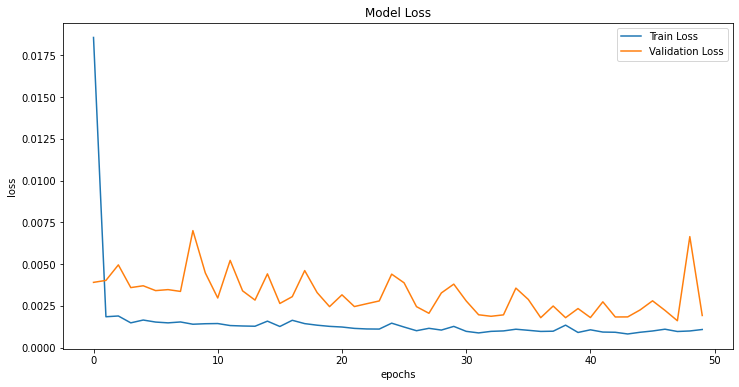

In [10]:
# Plot the model loss
fig = plt.figure(figsize=(12,6))

fig.add_subplot(111)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')

plt.show();

2/2 [==============================] - 0s 3ms/step


Text(0, 0.5, 'CLOSE PRICE')

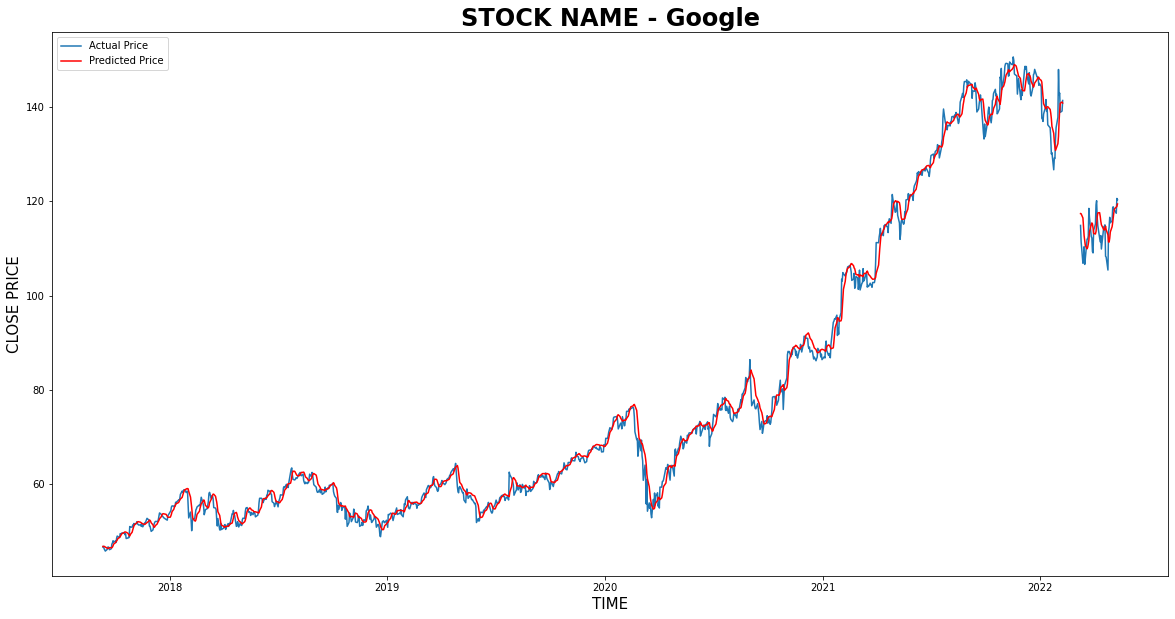

In [36]:
lb = LOOKBACK
x = df[:validation_ending_index+1].index.values

# prepare empty array with 'lb' size
emp = np.empty(lb, dtype='object')

def get_scaled_predictions(model, data, train_min, train_max):
    predictions = model.predict(data)
    return predictions * (train_max - train_min) + train_min

train_predict = get_scaled_predictions(model, x_train, train_min, train_max)
test_predict = get_scaled_predictions(model, x_test, train_min, train_max)

# combine the Train-Test results
allData = np.concatenate((emp, y_train * (train_max - train_min) + train_min, emp, y_test * (train_max - train_min) + train_min))
allPred = np.concatenate((emp, train_predict[:,0].reshape(train_predict.shape[0],),
                          emp, test_predict[:,0].reshape(test_predict.shape[0],)))

# plot the actual and prediction results
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
ax.plot(x, allData[1:], label="Actual Price")
ax.plot(x, allPred[1:], 'r', label="Predicted Price")
ax.legend()

# title
stock = 'Google'
ax.set_title("STOCK NAME - " + stock, fontsize=24, fontweight='bold')

# axis title
ax.set_xlabel('TIME', fontsize=15)
ax.set_ylabel('CLOSE PRICE', fontsize=15)

In [33]:
x

array(['2017-08-14T00:00:00.000000000', '2017-08-15T00:00:00.000000000',
       '2017-08-16T00:00:00.000000000', ...,
       '2022-05-09T00:00:00.000000000', '2022-05-10T00:00:00.000000000',
       '2022-05-11T00:00:00.000000000'], dtype='datetime64[ns]')